# Import Libraries
---

In [35]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pylab

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Saving
import pickle


# II. Data Loading
---

In [2]:
# Read data
df = pd.read_csv('./data_for_modelling.csv')

# Show 5 data
df.head()

,date,status,fulfilment,sales_channel,ship_service_level,category,size,amazon_standard_id,qty,currency,sales,clean_ship_state,promotion_used
0,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XL,B07WV4JV4D,1,INR,329.0,Maharashtra,True
1,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Top,3XL,B098714BZP,1,INR,574.0,Tamil Nadu,False
2,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,XL,B08YN7XDSG,1,INR,824.0,Uttar Pradesh,True
3,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,Set,L,B08CMHNWBN,1,INR,653.0,Chandigarh,True
4,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,kurta,XXL,B08B3XF5MH,1,INR,363.0,Tamil Nadu,False


In [3]:
# Show info from data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77785 entries, 0 to 77784
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                77785 non-null  object 
 1   status              77785 non-null  object 
 2   fulfilment          77785 non-null  object 
 3   sales_channel       77785 non-null  object 
 4   ship_service_level  77785 non-null  object 
 5   category            77785 non-null  object 
 6   size                77785 non-null  object 
 7   amazon_standard_id  77785 non-null  object 
 8   qty                 77785 non-null  int64  
 9   currency            77785 non-null  object 
 10  sales               77785 non-null  float64
 11  clean_ship_state    77785 non-null  object 
 12  promotion_used      77785 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(10)
memory usage: 7.2+ MB


In [4]:
# Change data type feature date to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by feature sales and quantity
df1 = df.groupby('date').agg(
    sales_sum=('sales', 'sum'), # sales is aggregated by summing
    qty_sum=('qty', 'sum') # qty is aggregated by averaging
).reset_index().sort_values('date')

# Set feature date as index
df1 = df1.set_index('date')

In [5]:
# Show info
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2022-03-31 to 2022-06-29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sales_sum  91 non-null     float64
 1   qty_sum    91 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 2.1 KB


In [6]:
# Knowing the frequency of the Day index
freq = pd.infer_freq(df1.index)
print(freq)

D


# III. Data Overview
---

In [8]:
# Plot data use plotly
fig = px.line(df1, x=df1.index, y="sales_sum", title='Sales Overtime')
fig.show()

## Decomposing
---

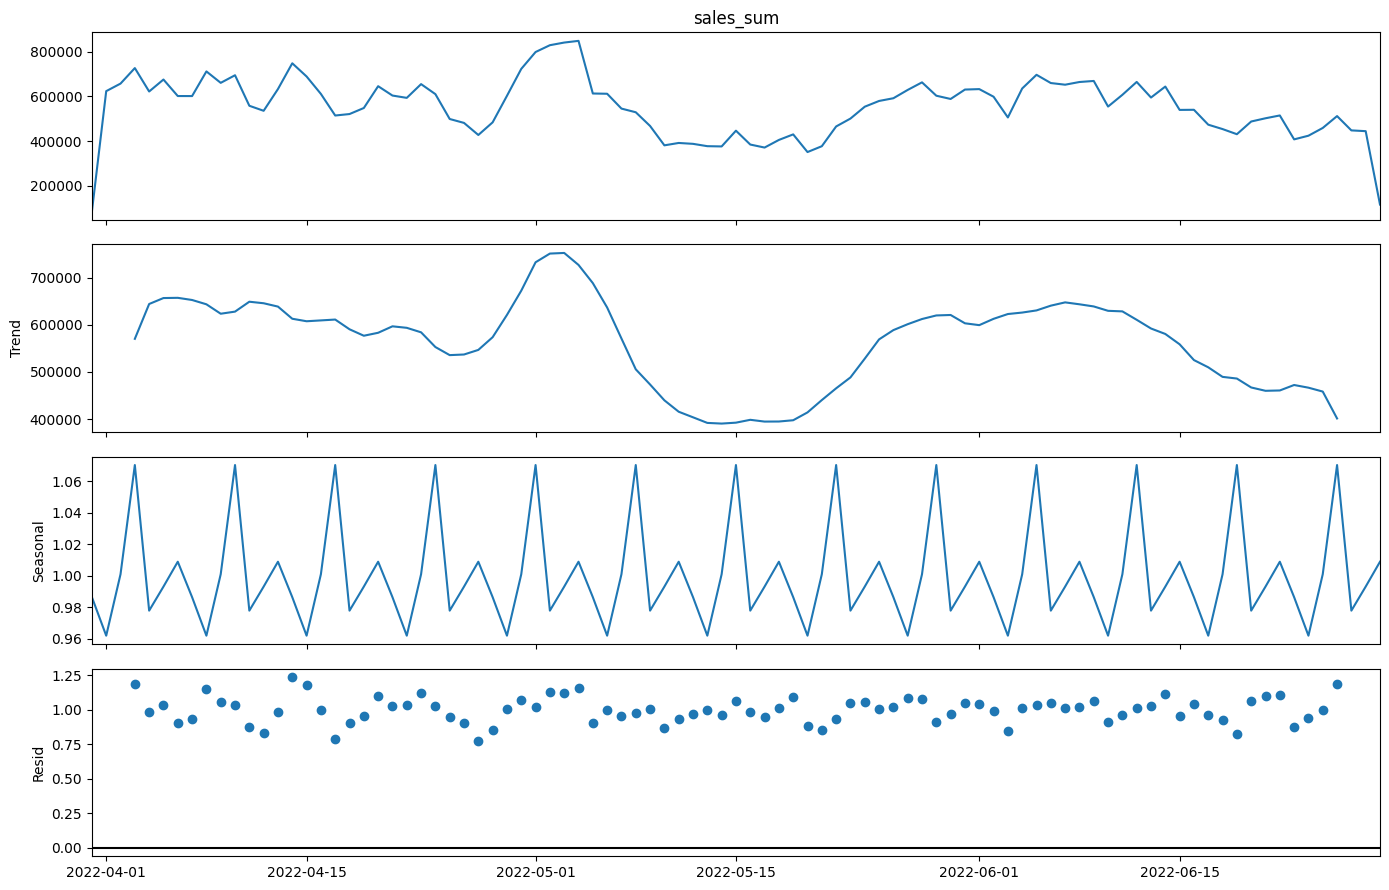

In [9]:
# Decompose the components from the time series.
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(df1['sales_sum'], model='multiplicative', period=7) # interval data: Day
ax=res.plot()
plt.show()

In [10]:
res = seasonal_decompose(df1['sales_sum'], model='multiplicative')

#Ambil index,
week = df1.index

fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=["Observed", "Trend", "Seasonal", "Residual"])

#Observed,
fig.add_trace(go.Scatter(x=week, y=res.observed, mode='lines', name='Observed'),
              row=1, col=1)

#Trend,
fig.add_trace(go.Scatter(x=week, y=res.trend, mode='lines', name='Trend'),
              row=2, col=1)

#Seasonal,
fig.add_trace(go.Scatter(x=week, y=res.seasonal, mode='lines', name='Seasonal'),
              row=3, col=1)

#Residual,
fig.add_trace(go.Scatter(x=week, y=res.resid, mode='lines', name='Residual'),
              row=4, col=1)

#Layout,
fig.update_layout(height=900, width=1000, title_text="Seasonal Decomposition (Multiplicative Model)", showlegend=False)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Value")

fig.show()


## Splitting Data
---

In [11]:
# knowing the length of data
len(df1)

91

In [12]:
# Use train : test -> 90% : 10%
train_len = int(len(df1) * 0.90)
train_len

81

In [13]:
# Splitting train dan test
train = df1[:train_len]
test = df1[train_len:]

print('Train size: ', train.shape)
print('Test size: ', test.shape)

Train size:  (81, 2)
Test size:  (10, 2)


In [15]:
# Create the figure
fig = go.Figure()

# Add traces for each DataFrame
fig.add_trace(go.Scatter(y=train['sales_sum'], x=train.index, mode='lines', name='Train'))
fig.add_trace(go.Scatter(y=test['sales_sum'], x=test.index, mode='lines', name='Test'))

# Update layout (optional)
fig.update_layout(title='Total Penjualan',
                  xaxis_title='Date',
                  yaxis_title='Sales')

# Show the figure
fig.show()

## Check Stationarity
---

H0: The data has a unit root and the data becomes non-stationary

H1: The data does not have a unit root and the data becomes stationary

In [14]:
# Create a function to check stationarity

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [20]:
# Check stationary of data
check_stationarity(df1['sales_sum'])

ADF Statistic: -3.921564
p-value: 0.001882
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584
Stationary


alpha = 0.05

p-value < alpha then H0 is rejected, which means the data does not have a unit root and the data is stationary. Since the data is stationary, no differencing is performed and the value of parameter d is 0.

## ACF & PACF
---

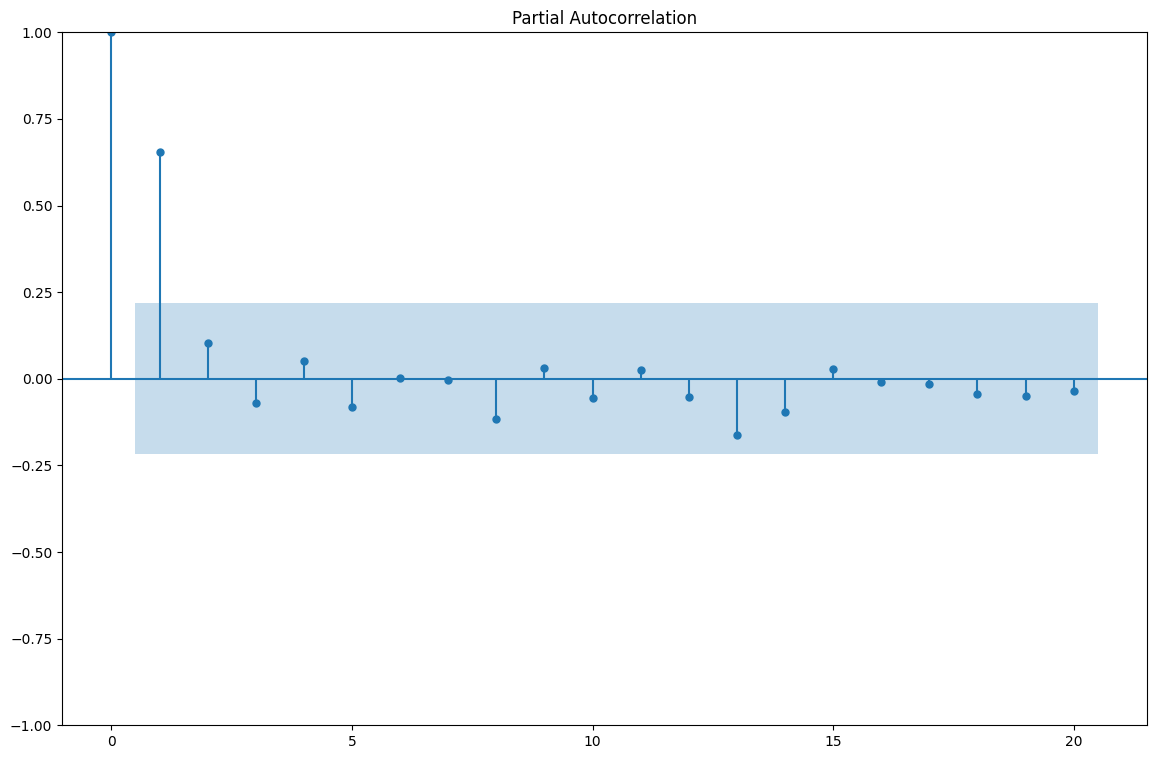

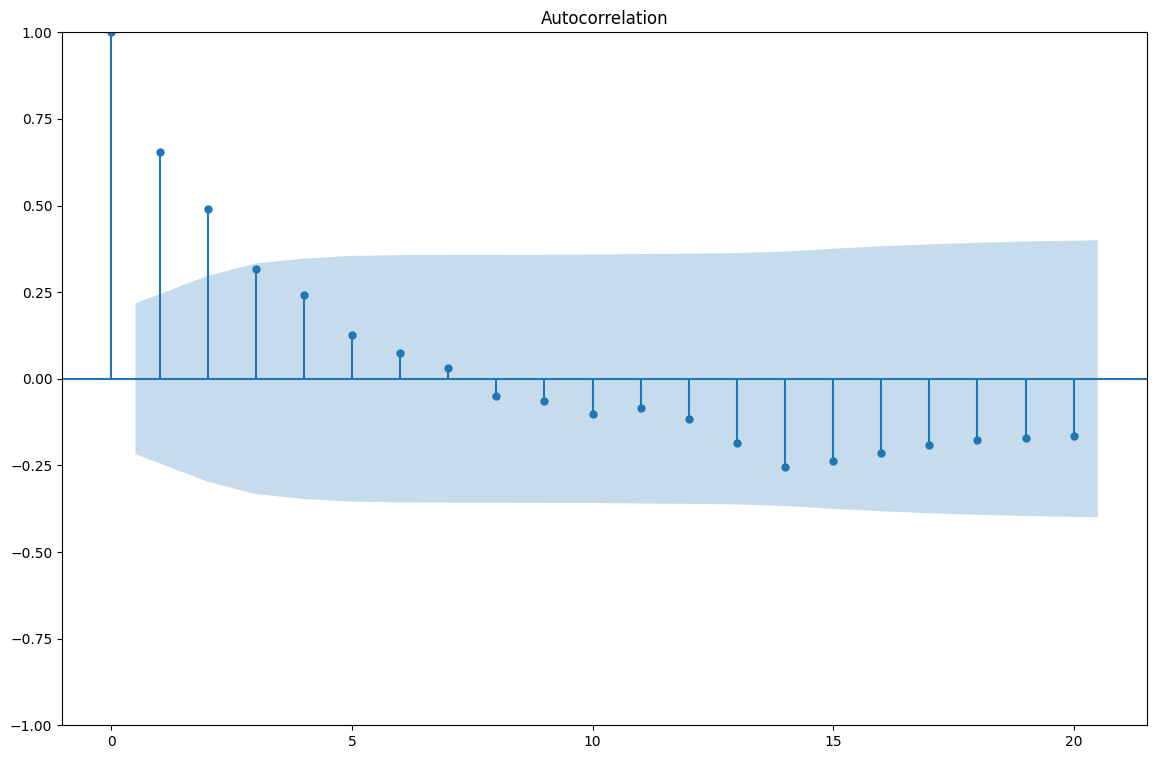

In [21]:
# Plot ACF & PACF
plot_pacf(train['sales_sum'])
plot_acf(train['sales_sum'])
plt.show()

## AIC
---

In [23]:
# function to get aic score, p, d, and q

def calculate_aic(data, num_p, num_d, num_q):
  # create empty df to store p, d, q, and aic score
  df1 = pd.DataFrame()

  # create empty list to store p, d, q
  pdq = [[], [], []]

  # create empty list to store aic score
  aic_score = []

  # looping to get p, d, q
  for lag_p in range(num_p + 1):
    for lag_d in range(num_d + 1):
      for lag_q in range(num_q + 1):
        # model definition
        model = SARIMAX(data, order=(lag_p, lag_d, lag_q))
        # model training
        result = model.fit()
        # filling empty list with aic score which generated from model training
        aic_score.append(result.aic)
        # filling empty list with lag_p, lag_d, and lag_q
        pdq[0].append(lag_p)
        pdq[1].append(lag_d)
        pdq[2].append(lag_q)

  # value placement to dataframe
  df1['AIC'] = aic_score
  df1['p'] = pdq[0]
  df1['d'] = pdq[1]
  df1['q'] = pdq[2]

  df1.sort_values('AIC', inplace=True)
  return df1

In [ ]:
# Find best model of SARIMAX with combinations of p=1, d=0, q=2
calculate_aic(train['sales_sum'], 1, 0, 2)

,AIC,p,d,q
3,2084.540964,1,0,0
4,2102.021971,1,0,1
5,2102.928988,1,0,2
2,2315.970305,0,0,2
1,2328.292671,0,0,1
0,2382.701867,0,0,0


# III. Model Definition and Training
---

## SARIMAX WITH EXOGENOUS
---

In [26]:
# Define exogenous variable as qty_sum
exog_vars = train[['qty_sum']]

# 
model_sar_exog = SARIMAX(train['sales_sum'], order=(0,0,1), seasonal_order=(0,0,1, 7), exog=exog_vars)

result_sar_exog = model_sar_exog.fit()

print("AIC Score: ", result_sar_exog.aic)

AIC Score:  1822.1336594426573


In [30]:
# Train prediction
pred_train_sar_exog = result_sar_exog.predict(start=train['sales_sum'].index[0], end=train['sales_sum'].index[-1], exog= exog_vars)
pred_train_sar_exog = pred_train_sar_exog.rename('predict')

# Train actual vs prediction
act_vs_pred_train_sar_exog = pd.concat([train['sales_sum'], pred_train_sar_exog], axis=1)
act_vs_pred_train_sar_exog

,sales_sum,predict
2022-03-31,84574.0,86713.514605
2022-04-01,623454.0,624788.721734
2022-04-02,657308.0,669971.775924
2022-04-03,726738.0,710826.137439
2022-04-04,621870.0,619091.430380
...,...,...
2022-06-15,539432.0,519552.842918
2022-06-16,539974.0,537283.049056
2022-06-17,473281.0,453296.283501
2022-06-18,453612.0,453476.767594


In [31]:
exog_vars_test = test[['qty_sum']]

# test prediction
pred_test_sar_exog = result_sar_exog.predict(start=test['sales_sum'].index[0], end=test['sales_sum'].index[-1], exog=exog_vars_test,  dynamic=False)
pred_test_sar_exog = pred_test_sar_exog.rename('predict')

# Concate with actual test-set
act_vs_pred_test_sar_exog = pd.concat([test['sales_sum'], pred_test_sar_exog], axis=1)
act_vs_pred_test_sar_exog

,sales_sum,predict
2022-06-20,487488.0,488583.803348
2022-06-21,501999.0,504845.797346
2022-06-22,514603.0,530002.727911
2022-06-23,407495.0,411521.950972
2022-06-24,423907.0,427077.237292
2022-06-25,458603.0,440320.252705
2022-06-26,511759.0,487747.052284
2022-06-27,447699.0,424030.898015
2022-06-28,444275.0,429713.639042
2022-06-29,115595.0,111121.763160


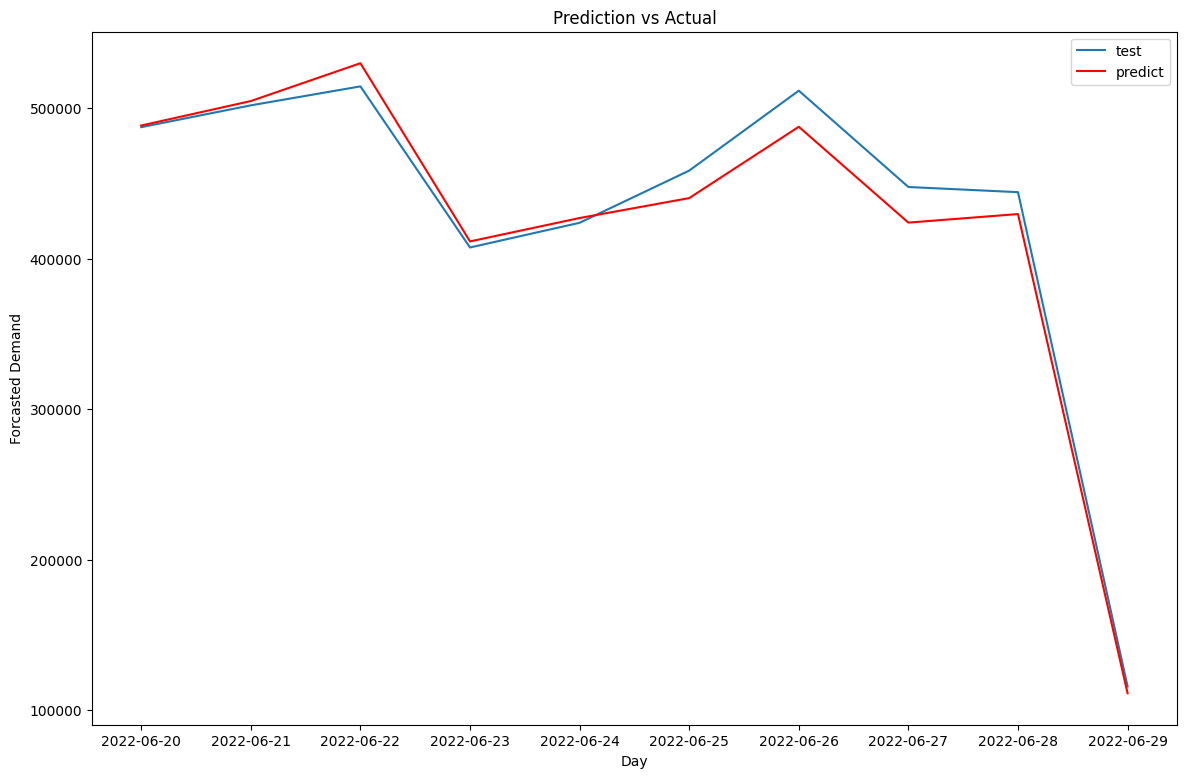

In [32]:
plt.plot(test['sales_sum'], label = 'test')
plt.plot(pred_test_sar_exog, color = 'red', label = 'predict')
plt.xlabel('Day')
plt.ylabel('Forcasted Demand')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()

### Evaluation
---

In [36]:
# Evaluation Train
mae_train_sar_exog = mean_absolute_error(train['sales_sum'], pred_train_sar_exog)

# Evaluation Test
mae_test_sar_exog = mean_absolute_error(test['sales_sum'], pred_test_sar_exog)

print(f"MAE Train : {mae_train_sar_exog}")
print(f"MAE Test : {mae_test_sar_exog}")

MAE Train : 13076.388731498817
MAE Test : 11153.691166244995


In [37]:
# Evaluation Train
mape_train_sar_exog = mean_absolute_percentage_error(train['sales_sum'], pred_train_sar_exog)

# Evaluation Test
mape_test_sar_exog = mean_absolute_percentage_error(test['sales_sum'], pred_test_sar_exog)

print(f"MAPE Train : {mape_train_sar_exog}")
print(f"MAPE Test : {mape_test_sar_exog}")

MAPE Train : 0.02336776440557518
MAPE Test : 0.026633080892998783


# IV. Model Saving
---

In [38]:
with open('model.pkl', 'wb') as model:
  pickle.dump(result_sar_exog, model)